In [30]:
import os 
import math
import torch
import pickle
import pandas as pd
import numpy as np
from tqdm import tqdm
from torch import nn
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, auc, roc_curve, balanced_accuracy_score
import seaborn as sn
%matplotlib inline

import sys
sys.path.append("..")
from metric.metric import metric

data_folder = '../data/'
np.random.seed(2022)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


### 8-neighbors 

In [31]:
columns = ['LU4', 'LC4', 'LU3', 'LC3', 'LU2', 'LC2', 'LU1', 'LC1', 'nbr1_LU3', 'nbr1_LC3', 'nbr1_LU2', 'nbr1_LC2', 'nbr1_LU1',
           'nbr1_LC1', 'nbr2_LU3', 'nbr2_LC3', 'nbr2_LU2', 'nbr2_LC2', 'nbr2_LU1', 'nbr2_LC1', 'nbr3_LU3', 'nbr3_LC3',
           'nbr3_LU2', 'nbr3_LC2', 'nbr3_LU1', 'nbr3_LC1', 'nbr4_LU3', 'nbr4_LC3', 'nbr4_LU2', 'nbr4_LC2', 'nbr4_LU1',
           'nbr4_LC1', 'nbr5_LU3', 'nbr5_LC3', 'nbr5_LU2', 'nbr5_LC2', 'nbr5_LU1', 'nbr5_LC1', 'nbr6_LU3', 'nbr6_LC3',
           'nbr6_LU2', 'nbr6_LC2', 'nbr6_LU1', 'nbr6_LC1', 'nbr7_LU3', 'nbr7_LC3', 'nbr7_LU2', 'nbr7_LC2', 'nbr7_LU1',
           'nbr7_LC1', 'nbr8_LU3', 'nbr8_LC3', 'nbr8_LU2', 'nbr8_LC2', 'nbr8_LU1', 'nbr8_LC1']


### Data loading

In [32]:
original_data = pd.read_csv(os.path.join(data_folder, 'trainset_with_neighbour.csv'), index_col=0)
original_data = original_data[columns]
original_data.head()

,LU4,LC4,LU3,LC3,LU2,LC2,LU1,LC1,nbr1_LU3,nbr1_LC3,...,nbr7_LU2,nbr7_LC2,nbr7_LU1,nbr7_LC1,nbr8_LU3,nbr8_LC3,nbr8_LU2,nbr8_LC2,nbr8_LU1,nbr8_LC1
RELI,,,,,,,,,,,,,,,,,,,,,
48561099,LU301,LC41,LU301,LC41,LU301,LC41,LU301,LC41,LU301,LC41,...,LU221,LC21,LU221,LC21,LU301,LC41,LU301,LC41,LU301,LC41
48611112,LU402,LC61,LU402,LC61,LU402,LC61,LU402,LC61,LU402,LC61,...,LU221,LC21,LU221,LC21,LU221,LC21,LU221,LC21,LU221,LC21
48621113,LU103,LC47,LU103,LC47,LU421,LC31,LU421,LC31,LU106,LC12,...,LU222,LC21,LU222,LC21,LU402,LC61,LU402,LC61,LU402,LC61
48621114,LU106,LC12,LU106,LC12,LU106,LC12,LU106,LC12,LU142,LC15,...,LU222,LC21,LU222,LC21,LU402,LC61,LU402,LC61,LU402,LC61
48621115,LU142,LC11,LU142,LC15,LU142,LC15,LU142,LC15,LU402,LC61,...,LU222,LC21,LU222,LC21,LU402,LC61,LU402,LC61,LU402,LC61


In [5]:
print('The length of the data with all rows is : {}'.format(len(original_data)))
original_data.dropna(inplace=True)
print('The length of the data without the rows with nan value is: {}'.format(len(original_data)))

The length of the data with all rows is : 348474
The length of the data without the rows with nan value is: 348474


In [6]:
data_features = original_data.copy()
data_features['changed'] = [0 if row['LU4'] == row['LU3'] and row['LC4'] == row['LC3'] else 1 for ind, row in data_features[['LU4', 'LC4', 'LU3', 'LC3']].iterrows()]
data_features.drop(['LC4', 'LU4'], axis=1, inplace=True)
data_features.head()

,LU3,LC3,LU2,LC2,LU1,LC1,nbr1_LU3,nbr1_LC3,nbr1_LU2,nbr1_LC2,...,nbr7_LC2,nbr7_LU1,nbr7_LC1,nbr8_LU3,nbr8_LC3,nbr8_LU2,nbr8_LC2,nbr8_LU1,nbr8_LC1,changed
RELI,,,,,,,,,,,,,,,,,,,,,
48561099,LU301,LC41,LU301,LC41,LU301,LC41,LU301,LC41,LU301,LC41,...,LC21,LU221,LC21,LU301,LC41,LU301,LC41,LU301,LC41,0
48611112,LU402,LC61,LU402,LC61,LU402,LC61,LU402,LC61,LU402,LC61,...,LC21,LU221,LC21,LU221,LC21,LU221,LC21,LU221,LC21,0
48621113,LU103,LC47,LU421,LC31,LU421,LC31,LU106,LC12,LU106,LC12,...,LC21,LU222,LC21,LU402,LC61,LU402,LC61,LU402,LC61,0
48621114,LU106,LC12,LU106,LC12,LU106,LC12,LU142,LC15,LU142,LC15,...,LC21,LU222,LC21,LU402,LC61,LU402,LC61,LU402,LC61,0
48621115,LU142,LC15,LU142,LC15,LU142,LC15,LU402,LC61,LU402,LC61,...,LC21,LU222,LC21,LU402,LC61,LU402,LC61,LU402,LC61,1


In [7]:
print('Total number of tiles that changed label in either Land Cover or Land Usage: %d' % sum(data_features.changed))

Total number of tiles that changed label in either Land Cover or Land Usage: 58737


In [8]:
def split_set(data_to_split, ratio=0.8):
    mask = np.random.rand(len(data_to_split)) < ratio
    return [data_to_split[mask], data_to_split[~mask], mask]

In [9]:
train, test, mask = split_set(data_features)
train, val, _ = split_set(train)

# one-hot encoder to make categorical features as columns with 0-1
# Make sure we use only the features available in the training set
train_categorical = pd.get_dummies(train)
val_categorical = pd.get_dummies(val)[train_categorical.columns]
test_categorical = pd.get_dummies(test)[train_categorical.columns]

train_label = train_categorical.changed
train_features = train_categorical.drop('changed', axis=1)
print('Length of the train dataset : {}'.format(len(train_label)))

val_label = val_categorical.changed
val_features = val_categorical.drop('changed', axis=1)
print('Length of the validation dataset : {}'.format(len(val_label)))

test_label=test_categorical.changed
test_features = test_categorical.drop('changed', axis=1)
print('Length of the test dataset : {}'.format(len(test_label)))

Length of the train dataset : 222545
Length of the validation dataset : 55653
Length of the test dataset : 70276


# Evaluation

## Logistic regression

In [36]:
def compute_confusion_matrix(true_label, prediction_proba, decision_threshold=0.5): 
    
    predict_label = (prediction_proba[:,1]>decision_threshold).astype(int)   
    
    TP = np.sum(np.logical_and(predict_label==1, true_label==1))
    TN = np.sum(np.logical_and(predict_label==0, true_label==0))
    FP = np.sum(np.logical_and(predict_label==1, true_label==0))
    FN = np.sum(np.logical_and(predict_label==0, true_label==1))
    
    confusion_matrix = np.asarray([[TP, FP],
                                    [FN, TN]])
    return confusion_matrix


def plot_confusion_matrix(confusion_matrix, thred, axs):
    [[TP, FP],[FN, TN]] = confusion_matrix
    label = np.asarray([['TP {}'.format(TP), 'FP {}'.format(FP)],
                        ['FN {}'.format(FN), 'TN {}'.format(TN)]])
    
    df_cm = pd.DataFrame(confusion_matrix, index=['Yes', 'No'], columns=['Positive', 'Negative']) 
    
    sn.heatmap(df_cm, cmap='YlOrRd', annot=label, annot_kws={"size": 16}, cbar=False, fmt='',ax=axs)
    axs.set_xlabel('Actual')
    axs.set_ylabel('Predicted')
    axs.set_title('Confusion matrix for a {} threshold'.format(thred))
    


def compute_all_score(confusion_matrix, t=0.5):
    
    [[TP, FP],[FN, TN]] = confusion_matrix.astype(float)
    
    precision_positive = TP/(TP+FP) if (TP+FP) !=0 else np.nan
    precision_negative = TN/(TN+FN) if (TN+FN) !=0 else np.nan
    
    recall_positive = TP/(TP+FN) if (TP+FN) !=0 else np.nan
    recall_negative = TN/(TN+FP) if (TN+FP) !=0 else np.nan

    F1_score_positive = 2 *(precision_positive*recall_positive)/(precision_positive+recall_positive) if (precision_positive+recall_positive) !=0 else np.nan
    F1_score_negative = 2 *(precision_negative*recall_negative)/(precision_negative+recall_negative) if (precision_negative+recall_negative) !=0 else np.nan
    
    accuracy =  (TP+TN)/np.sum(confusion_matrix)
    balanced_acc = (recall_negative + recall_positive) / 2

    return [t, accuracy, balanced_acc, precision_positive, recall_positive, F1_score_positive, precision_negative, recall_negative, F1_score_negative]

In [33]:
# Load model weights if already trained 
# pkl_filename = "./temp_results/logistic_regression_baseline.pkl"
pkl_filename = "./temp_results/logistic_regression_macro.pkl"
with open(pkl_filename, 'rb') as file:
    logistic = pickle.load(file)

In [34]:
prediction_proba = logistic.predict_proba(test_features)

In [37]:
mat_test = compute_confusion_matrix(test_label, prediction_proba)

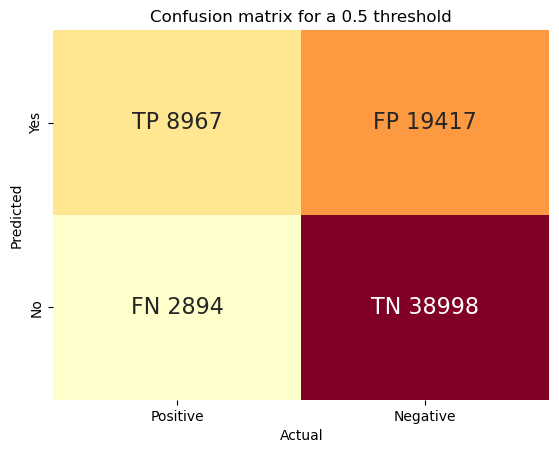

In [38]:
axs = plt.subplot(111)
plot_confusion_matrix(mat_test, thred=0.5, axs=axs)

In [39]:
# build df_change for constant model
df_change = pd.DataFrame(test_label)
df_change['proba_change'] = np.zeros_like(prediction_proba[:,1])
df_change.reset_index(inplace=True)

In [40]:
# build df_change for ML model
df_change = pd.DataFrame(test_label)
df_change['proba_change'] = prediction_proba[:,1]
df_change.reset_index(inplace=True)

In [41]:
pred_lc = pd.read_csv(os.path.join(data_folder, 'predictions_lc_area4.csv'), index_col=0)
pred_lc.rename(columns={"prediction": "prediction_lc", "confidence": "confidence_lc"}, inplace=True)
pred_lu = pd.read_csv(os.path.join(data_folder, 'predictions_lu_area4.csv'), index_col=0)
pred_lu.rename(columns={"prediction": "prediction_lu", "confidence": "confidence_lu"}, inplace=True)
metric(mode='multi', PROBABILITY_THRESHOLD=0.5, change_pred=df_change, lc_pred=pred_lc.reset_index(), lu_pred=pred_lu.reset_index())

Length of filtered data: 47482
balanced accuracy: 0.685
recall: 0.965
true negative rate: 0.405
missed changes: 269
missed changes w.r.t total changes: 0.035
missed weighted change: 10843
missed weighted changes w.r.t total weighted changes: 0.020
automatized points: 16410
automatized capacity: 0.412
raw metric: 0.266
weighted metric: 0.329


[0.5,
 0.6847139011131885,
 0.9646378335743394,
 0.4047899686520376,
 269,
 0.03536216642566058,
 10843.0,
 0.019988754827589387,
 16410,
 0.41153605015673983,
 0.26600798719872354,
 0.3292751180637638]

In [42]:
# Metric mode 'binary' uses only change probability as input together 
metric(mode='binary', PROBABILITY_THRESHOLD=0.22, change_pred=df_change)

Length of filtered data: 47491
balanced accuracy: 0.655
recall: 0.954
true negative rate: 0.355
missed changes: 349
missed changes w.r.t total changes: 0.046
missed weighted change: 18995
missed weighted changes w.r.t total weighted changes: 0.035
automatized points: 14516
automatized capacity: 0.364
raw metric: 0.197
weighted metric: 0.237


[0.22,
 0.6546631494644579,
 0.9541212041540686,
 0.3552050947748471,
 349,
 0.04587879584593138,
 18995.0,
 0.0350167294982994,
 14516,
 0.36395547086551,
 0.1969770834170244,
 0.23651016813827253]

In [44]:
threshold = np.linspace(0, 1, 101)
columns_score_name = ['Threshold', 'balanced_acc', 'true_pos_rate', 'true_neg_rate', 'miss_changes', 'miss_changed_ratio', 'miss_weighted_changes', 'miss_weighted_changed_ratio', 
            'automatized_points', 'automatized_capacity', 'raw_metric', 'weighted_metric']
threshold_score = pd.concat([pd.DataFrame([metric(mode='binary', PROBABILITY_THRESHOLD=t, change_pred=df_change, print_log=False)], columns=columns_score_name) for t in threshold],
                            ignore_index=True)
threshold_score.set_index('Threshold', inplace=True)

Text(0.5, 1.0, 'weighted_metric')

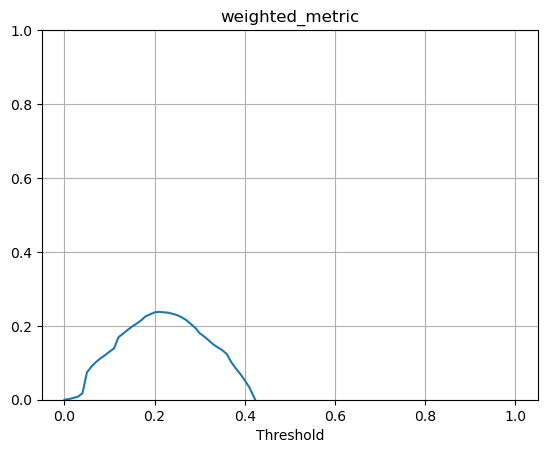

In [45]:
threshold_score['weighted_metric'].plot(grid=True, ylim=[0,1]).set_title('weighted_metric')

In [46]:
threshold_score.iloc[threshold_score['weighted_metric'].argmax()]

balanced_acc                       0.647662
true_pos_rate                      0.958722
true_neg_rate                      0.336601
miss_changes                     314.000000
miss_changed_ratio                 0.041278
miss_weighted_changes          16813.000000
miss_weighted_changed_ratio        0.030994
automatized_points             13739.000000
automatized_capacity               0.344474
raw_metric                         0.202283
weighted_metric                    0.237707
Name: 0.21, dtype: float64

In [47]:
thred = threshold_score.iloc[threshold_score['weighted_metric'].argmax()].name
thred

0.21

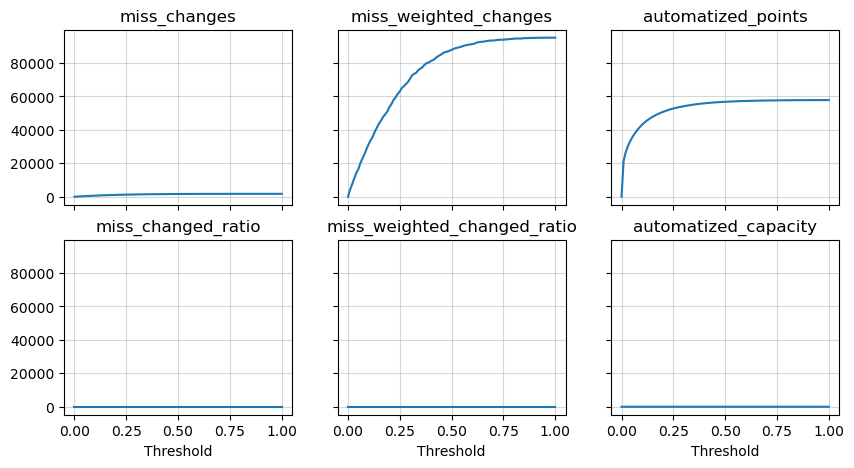

In [53]:
fig, axs = plt.subplots(nrows=2, ncols=3, sharex=True, sharey=True, figsize=(10,5))

col_plot = ['miss_changes', 'miss_weighted_changes', 'automatized_points',
            'miss_changed_ratio','miss_weighted_changed_ratio',  'automatized_capacity']

major_ticks = np.linspace(0,1,5)

for axe, col in zip(axs.flat, col_plot):
    threshold_score[col].plot(ax=axe, grid = True)
    axe.set_title(col)
    axe.set_xticks(major_ticks)    
    axe.grid(which='major', alpha=0.5)

## Extract features

In [40]:
train_proba = logistic.predict_proba(train_features)
train_proba_df = pd.DataFrame(train_proba, index=train.index, columns=['p_unchage', 'p_change'])
train_proba_df = pd.concat([train_proba_df, train_label], axis=1)
test_proba_df = pd.DataFrame(prediction_proba, index=test.index, columns=['p_unchage', 'p_change'])
test_proba_df = pd.concat([test_proba_df, test_label], axis=1)
logreg_proba = pd.concat([train_proba_df, test_proba_df], axis=0)
logreg_proba.sort_index(inplace=True)
logreg_proba = logreg_proba.merge(data_features[['LC3', 'LU3']], on='RELI')
logreg_proba.head()

,p_unchage,p_change,changed,LC3,LU3
RELI,,,,,
48561099,0.319364,0.680636,0,LC41,LU301
48611112,0.847969,0.152031,0,LC61,LU402
48621113,0.356399,0.643601,0,LC47,LU103
48621114,0.876144,0.123856,0,LC12,LU106
48621115,0.339232,0.660768,1,LC15,LU142


In [41]:
with open('./temp_results/temporal_spatial_proba_lr.pkl', 'wb') as file:
    pickle.dump(logreg_proba, file)

# Pytorch model

In [20]:
X_train = torch.Tensor(train_features.values).cuda()
y_train = torch.Tensor(train_label.values).cuda()

X_val = torch.Tensor(val_features.values).cuda()
y_val = torch.Tensor(val_label.values).cuda()

X_test = torch.Tensor(test_features.values).cuda()
y_test = torch.Tensor(test_label.values).cuda()

In [21]:
def compute_confusion_matrix(true_label, prediction_proba, decision_threshold=0.5): 
    
    predict_label = torch.where(prediction_proba>decision_threshold,torch.ones_like(prediction_proba),torch.zeros_like(prediction_proba))
    
    TP = torch.sum(torch.logical_and(predict_label==1, true_label==1)).cpu()
    TN = torch.sum(torch.logical_and(predict_label==0, true_label==0)).cpu()
    FP = torch.sum(torch.logical_and(predict_label==1, true_label==0)).cpu()
    FN = torch.sum(torch.logical_and(predict_label==0, true_label==1)).cpu()
    
    confusion_matrix = np.asarray([[TP, FP],
                                    [FN, TN]])
    return confusion_matrix


def plot_confusion_matrix(confusion_matrix):
    [[TP, FP],[FN, TN]] = confusion_matrix
    label = np.asarray([['TP {}'.format(TP), 'FP {}'.format(FP)],
                        ['FN {}'.format(FN), 'TN {}'.format(TN)]])

    df_cm = pd.DataFrame(confusion_matrix, index=['Yes', 'No'], columns=['Positive', 'Negative']) 

    sn.heatmap(df_cm, cmap='YlOrRd', annot=label, annot_kws={"size": 16}, cbar=False, fmt='')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title('Confusion matrix')
    


def compute_all_score(confusion_matrix, t=0.5):
    
    [[TP, FP],[FN, TN]] = confusion_matrix.astype('float')
    
    precision_positive = TP/(TP+FP) if (TP+FP) !=0 else np.nan
    precision_negative = TN/(TN+FN) if (TN+FN) !=0 else np.nan
    
    recall_positive = TP/(TP+FN) if (TP+FN) !=0 else np.nan
    recall_negative = TN/(TN+FP) if (TN+FP) !=0 else np.nan

    F1_score_positive = 2 *(precision_positive*recall_positive)/(precision_positive+recall_positive) if (precision_positive+recall_positive) !=0 else np.nan
    F1_score_negative = 2 *(precision_negative*recall_negative)/(precision_negative+recall_negative) if (precision_negative+recall_negative) !=0 else np.nan
    
    accuracy =  (TP+TN)/np.sum(confusion_matrix)
    balanced_acc = (recall_negative + recall_positive) / 2
    precision_metrix = FN / (FN +TN)

    return [t, accuracy, balanced_acc, precision_positive, recall_positive, F1_score_positive, precision_negative, recall_negative, F1_score_negative, precision_metrix]

In [25]:
class FCN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(FCN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 2048)
        self.fc2 = nn.Linear(2048, 2048)
        self.fc5 = nn.Linear(2048, 1024)
        self.fc6 = nn.Linear(1024, 512)
        self.fc7 = nn.Linear(512, output_dim)


    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc5(x))
        x = torch.relu(self.fc6(x))
        x = torch.sigmoid(self.fc7(x))   
        
        return x


In [26]:
network_in = './temporal_spatial/ckpt-Focal_loss-0.95-3-lr2e-06/ckpt-59.pth'

input_dim = len(test_features.columns)
output_dim = 1 

model = FCN(input_dim, output_dim).cuda()
# model = IntegrateNet(input_dim, output_dim).cuda()

model.load_state_dict(torch.load(network_in), strict=True)
model = model.cuda()

# Calculating the loss and accuracy for the validation dataset
outputs_test = torch.squeeze(model(X_test))
mat_test = compute_confusion_matrix(y_test, outputs_test)


In [27]:
df_change = pd.DataFrame(test_label)
df_change['proba_change'] = outputs_test.cpu().detach().numpy()
df_change.reset_index(inplace=True)

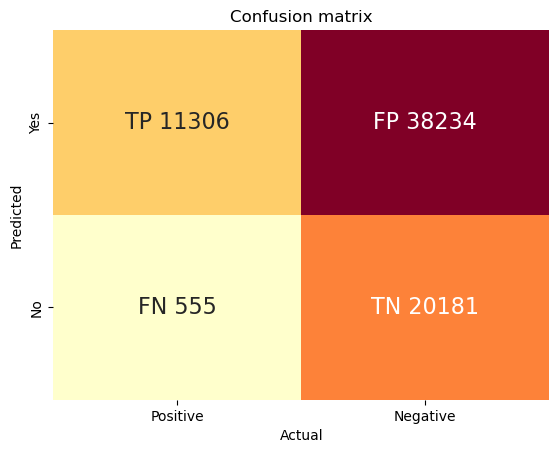

In [28]:
plot_confusion_matrix(mat_test)

In [29]:
metric(mode='binary', PROBABILITY_THRESHOLD=0.5, change_pred=df_change)

Length of filtered data: 47491
balanced accuracy: 0.656
recall: 0.958
true negative rate: 0.355
missed changes: 322
missed changes w.r.t total changes: 0.042
missed weighted change: 15563
missed weighted changes w.r.t total weighted changes: 0.029
automatized points: 14490
automatized capacity: 0.363
raw metric: 0.210
weighted metric: 0.259


[0.5,
 0.6564503670345593,
 0.95767056658341,
 0.35523016748570857,
 322,
 0.042329433416589984,
 15563.0,
 0.028689937414163386,
 14490,
 0.363303580383111,
 0.20951923322475455,
 0.25907201054778173]

# Extract features

In [19]:
train_proba = torch.squeeze(model(X_train)).cpu().detach().numpy()
train_proba_df = pd.DataFrame([[p_not, p] for p_not, p in zip(1-train_proba, train_proba)], index=train.index, columns=['p_unchage', 'p_change'])
train_proba_df = pd.concat([train_proba_df, train_label], axis=1)

val_proba = torch.squeeze(model(X_val)).cpu().detach().numpy()
val_proba_df = pd.DataFrame([[p_not, p] for p_not, p in zip(1-val_proba, val_proba)], index=val.index, columns=['p_unchage', 'p_change'])
val_proba_df = pd.concat([val_proba_df, val_label], axis=1)

test_proba = torch.squeeze(model(X_test)).cpu().detach().numpy()
test_proba_df = pd.DataFrame([[p_not, p] for p_not, p in zip(1-test_proba, test_proba)], index=test.index, columns=['p_unchage', 'p_change'])
test_proba_df = pd.concat([test_proba_df, test_label], axis=1)

proba_df = pd.concat([train_proba_df, val_proba_df, test_proba_df], axis=0)
proba_df.sort_index(inplace=True)
proba_df = proba_df.merge(data_features[['LC3', 'LU3']], on='RELI')
proba_df.head()

,p_unchage,p_change,changed,LC3,LU3
RELI,,,,,
48561099,0.339599,0.660401,0,LC41,LU301
48611112,0.552779,0.447221,0,LC61,LU402
48621113,0.349247,0.650753,0,LC47,LU103
48621114,0.563225,0.436775,0,LC12,LU106
48621115,0.387474,0.612526,1,LC15,LU142


In [20]:
# Save to file
with open('./temp_results/temporal_spatial_proba_FCN.pkl', 'wb') as file:
    pickle.dump(proba_df, file)